## Twitter Sentiment Analysis 

### Naive Bayes

The usual data science workflow is to quickly train and evaluate several models before any further work so as to short-list a few promising models. The lengthy hyperparameter tuning and robust cross-validation is then conducted on the selected models.

The usual sentiment analysis workflow is to apply latent semantic analysis (LSA) using singular vector decomposition (SVD) so as to avoid the curse of dimensionality, whereby it is impractical to train most models.


As a first stab on predicting positive and negative Tweets, I'm bypassing both these workflows to train Naive Bayes alone as a first step, since:
1. it is a super fast algorithm that won't suffer with our large feature  (next step would be to reduce it to most common words)
2. not requiring SVD means we can look at our predictions and try to understand how the classifier is working on unigrams (and possibly bigrams) and not on harder-to-interpret features built out of those through SVD

In [24]:
import os 
import time

import functools
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

start_notebook = time.time()

### Load Pre-Processed Data


In [25]:
# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")

# load X_bow matrices
X_bow_ung = sp.load_npz(os.path.join(proc_dir, "X_bow_ung.npz"))
X_bow_big = sp.load_npz(os.path.join(proc_dir, "X_bow_big.npz"))

# load y target vector
y_filepath = os.path.join(proc_dir, "y_train.npy")

with open(y_filepath, 'rb') as f:
    y_train = np.load(f)
    
y_train = y_train.ravel() # contiguous flattened array

### Naive Bayes

In [28]:
# instantiate classifier
NB_clf = MultinomialNB()

In [29]:
cv_res_NBung = cross_val_score(NB_clf, X_bow_ung, y_train, cv=10, scoring="accuracy")
cv_res_NBbig = cross_val_score(NB_clf, X_bow_big, y_train, cv=10, scoring="accuracy")

In [31]:
def plot_cv_res(cv_res, title, ylim=[.3, .7]):
    fig = plt.figure(figsize=(8, 4))   
    mn_res = np.mean(cv_res)
    plt.plot(cv_res, 'b--', linewidth=.8, label="accuracy")
    plt.axhline(y=mn_res, color='r', linestyle='-', linewidth=.5, 
                label=' '.join(["mean", "accuracy"]))
    plt.title(''.join(["CV results - ", title]), fontsize=16)
    plt.xlabel("CV folds", fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    plt.ylim(ylim)
    plt.show()

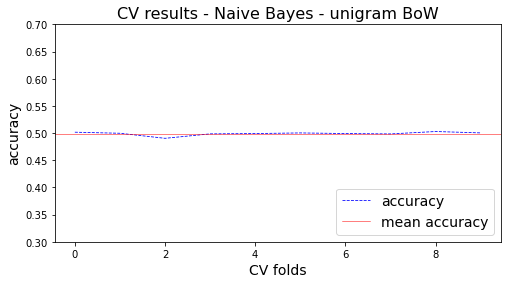

In [32]:
plot_cv_res(cv_res_NBung, 'Naive Bayes - unigram BoW')

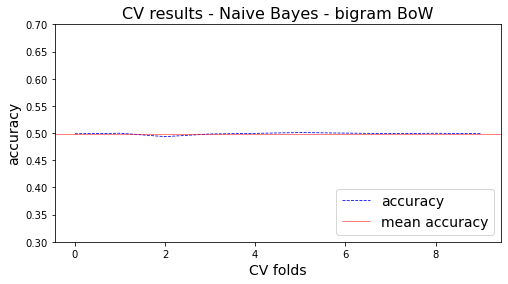

In [34]:
plot_cv_res(cv_res_NBbig, 'Naive Bayes - bigram BoW')

### SGD

In [11]:
from sklearn.linear_model import SGDClassifier

SGD_clf = SGDClassifier(n_jobs=-1, random_state=42)

In [13]:
SGD_cv_res = cross_val_score(SGD_clf, X_bow, y_train, cv=5, scoring="accuracy", verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.501, total=   5.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] .................................... , score=0.500, total=   4.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


[CV] .................................... , score=0.499, total=   4.6s
[CV]  ................................................................
[CV] .................................... , score=0.502, total=   4.5s
[CV]  ................................................................
[CV] .................................... , score=0.501, total=   4.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.2s finished


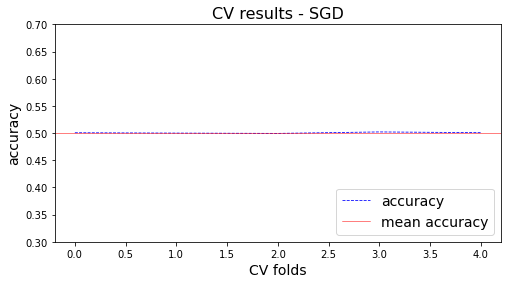

In [15]:
plot_cv_res(SGD_cv_res, 'SGD')

####  Learning Curves

Adapted code from sklearn's [plot_learning_curve example.](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)


In [17]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), 
                        scoring='accuracy'):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        
        Note that for classification the number of samples usually has to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
        
    scoring : string
        Evaluation metric for scores, see model_evaluation for available
        metrics (default='accuracy').
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(scoring)

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring=scoring,
                       return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label=''.join(["Training ", scoring]))
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label=''.join(["Cross-validation ", scoring]))
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")

    return plt

In [18]:
# Cross validation with n_splits iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv_folds = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
NB_clf = MultinomialNB()
SGD_clf = SGDClassifier(random_state=42)

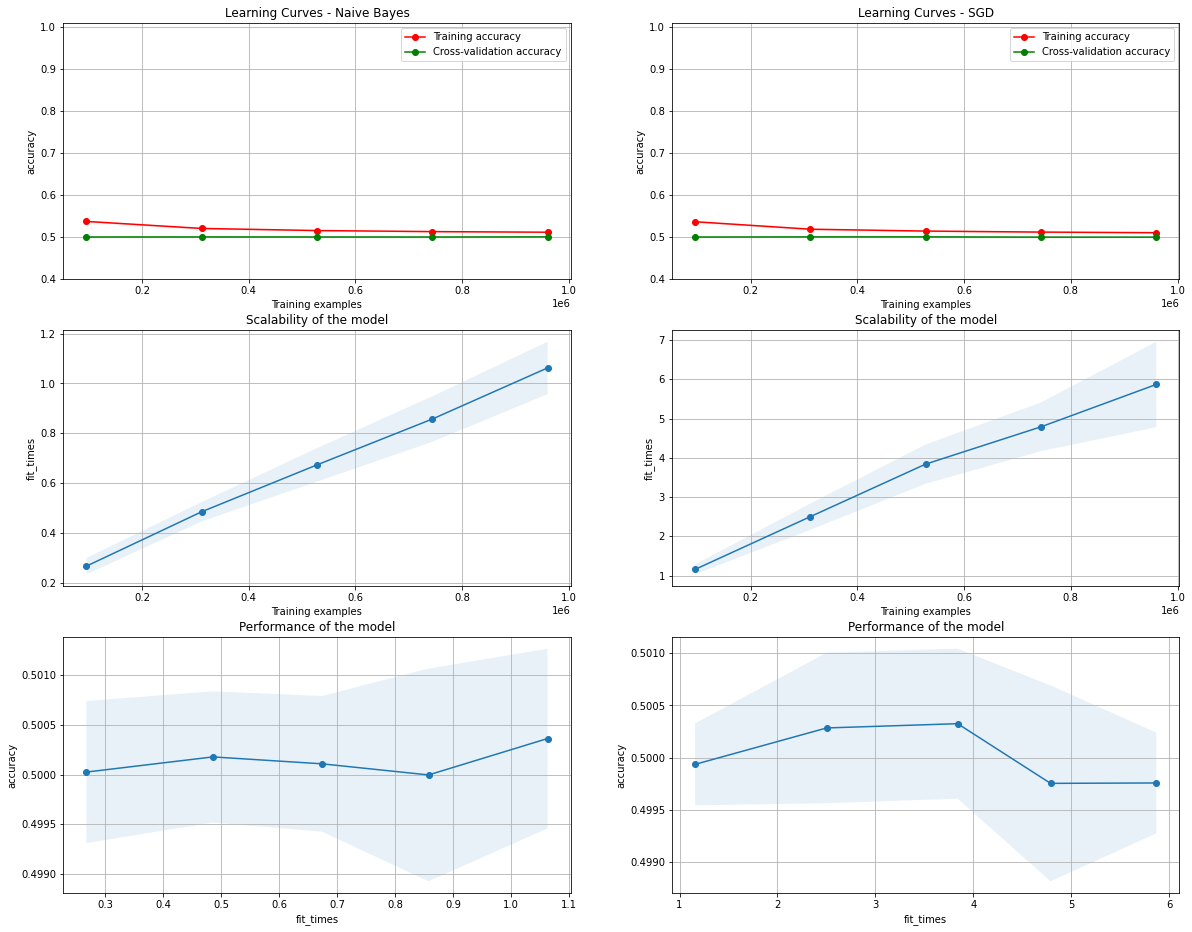

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16))

title1 = "Learning Curves - Naive Bayes"
plot_learning_curve(NB_clf, title1, X_bow, y_train, 
                    axes=axes[:, 0], ylim=(0.4, 1.01),
                    cv=cv_folds, n_jobs=2, scoring='accuracy')

title2 = "Learning Curves - SGD"
plot_learning_curve(SGD_clf, title2, X_bow, y_train, 
                    axes=axes[:, 1], ylim=(0.4, 1.01),
                    cv=cv_folds, n_jobs=2, scoring='accuracy')
plt.show()

Quick version of the above using accuracy:

In [20]:
def plot_learning_curves(model, X, y, Xname):
    """Plot the learning curves for train and validation sets:
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=34)
    train_acc, val_acc = [], []

    data_granularity = 100000  # plot every 100,000th data point
    xs = []
    for m in range(1, X_train.shape[0], data_granularity):       
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        val_acc.append(accuracy_score(y_val, y_val_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, round(X_train.shape[0]/data_granularity, 0), 0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, label="train accuracy")
    plt.plot(xs, np.sqrt(val_acc), 'b--', linewidth=.8, label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", Xname]), fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

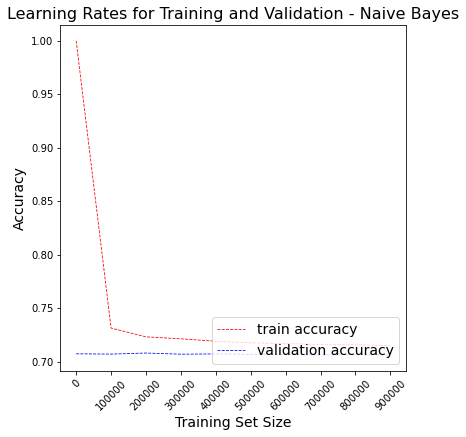

In [21]:
plot_learning_curves(NB_clf, X_bow, y_train, 'Naive Bayes')

In [1]:
#plot_learning_curves(SGD_clf, X_bow, y_train, 'SGD')

In [22]:
end_notebook = time.time()
mins, secs = divmod(end_notebook - start_notebook, 60)
print(f"Total elapsed time: {mins:0.0f} minutes and {secs:0.0f} seconds.")

Total elapsed time: 5 minutes and 51 seconds.


---